# Tutorial 4 - Objective magnification

Welcome to the fourth tutorial of this series!
In this notebook, we'll investigate the effect of the objective magnification on the structure function.
This allows us to extend the range of wave vectors that can be analyzed with DDM to **lower** values.

### Purpose

The goal of this tutorial is to demonstrate the effect of the objective magnification on the results obtained by DDM.
Specifically, we will:

0. Set up the workspace and import the libraries
    1. Set up the workspace.
    2. Give an overview of the sample under investigation.
    3. Import libraries.
1. Compute the structure function of image sequences using DDM.
    1. Load the image sequences and see the effect of different objective magnifications on the input images.
    2. Calculate the corresponding structure functions.
    3. Calculate the azimuthal averages.
2. Fit the azimuthal average to gain insights into the sample's dynamics.
    1. Estimate the parameters.
    2. Fit the data using a diffusive dynamics model.
    3. Observe the effect of the objective magnification on the limits of the technique.
    4. Fit the parameters obtained from the fit to the data to retrieve the diffusion coefficient of the particles.
3. Investigate the effect of the objective magnification and average intensity on the amplitude and noise of the structure function
    1. Repeat the calculation of the structure function and azimuthal average calculation for a different set of measurements.
    2. Observe the effect of the objective magnification and intensity on the amplitude and noise.

This tutorial assumes that you have a basic understanding of the features offered by fastDDM. If you need a refresher, consider reviewing the ["zeroth" tutorial](../Tutorial_0-Introduction/tutorial0.ipynb).
It also builds on top of the previous tutorials [1](../Tutorial_1-Particle_sizing/tutorial1.ipynb) and [2](../Tutorial_2-Melt/tutorial2.ipynb).

At the end of the notebook, there will be an optional (starred) section:

* (*): Figures for the objective magnification section of the paper.

## 0. Initial setup

### 0.A. Setting up your workspace

Before we dive into the analysis, make sure you have **fastDDM** and the required scientific analysis, fitting, and visualization packages installed on your machine. Refer to the main [README](../README.md) for installation instructions.

For this tutorial, we'll be using custom microscopy videos acquired for these tutorials.
If you haven't done so already, download the files (the `DATASET` folder) in the directory containing these tutorials.

Your main directory tree should resemble the following:
```
.
├── DATASET
│   └── ...
├── Tutorial_4-Objective_magnification
└── ...
```

### 0.B. Sample description and experimental parameters

The sample under study consists of a dilute solution of polystyrene spheres (PS, nominal diameter 252 nm, Microparticles GmbH) dispersed in a glycerol aqueous solution ($c_{\text{gly}} = 21.5\%$) to prevent sedimentation.
The sample was prepared at a volume fraction $\phi=10^{-3}$ and loaded into a 0.3 $\times$ 3 $\times$ 50 mm glass capillary (Vitrocom).
The experiments were performed at $T \simeq 21^{\circ}\mathrm{C}$ (solvent viscosity $\eta = 1.78 \, \mathrm{mPa \, s}$).

The videos were acquired at 108 and 1 fps for the fast and slow acquisition, respectively, using a Nikon Eclipse Ti2 inverted microscope equipped with a Prime BSI Express CMOS camera (pixel size $6.5 \, \mathrm{µm}$).
Each set of videos was acquired using objectives with different magnification:
* 10$\times$, NA 0.45
* 20$\times$, NA 0.45
* 60$\times$, NA 0.7

The effective pixel size is calculated according to $\delta_{px} = 6.5/m_o \, \mathrm{µm}$, where $m_o$ is the objective magnification.
This gives in the three cases $650$, $325$, and $108 \, \mathrm{nm}$.
The image sequences are composed of 10000 frames each, 256$\times$256 pixels.

### 0.C. Let's get started

Let's import some essential libraries, including `fastDDM`.

In [1]:
%matplotlib inline

import gc
import os
import lmfit
import numpy as np

# set numpy print options to limit the length of the output
np.set_printoptions(threshold=0)

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

# get rid of the 'too many open images' warning
mpl.rcParams.update({'figure.max_open_warning': 0,
                     'figure.dpi': 300})

# color space helper
def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

# fastddm
import fastddm as fd
from fastddm.fit import fit

Here, we define the paths to the videos and the labels.

In [2]:
# directory containing the videos
main_directory = '../DATASET/'

# high frame rate videos file names (including enclosing folder)
file_names_fast = [
    'PS_252nm_phi_1e-3_10x_NA_0-45/fast.nd2',
    'PS_252nm_phi_1e-3_20x_NA_0-45/fast.nd2',
    'PS_252nm_phi_1e-3_60x_NA_0-7/fast.nd2',
]

# create full paths
file_paths_fast = [
    os.path.join(main_directory, fn) for fn in file_names_fast
]

# low frame rate videos file names (including enclosing folder)
file_names_slow = [
    'PS_252nm_phi_1e-3_10x_NA_0-45/slow.nd2',
    'PS_252nm_phi_1e-3_20x_NA_0-45/slow.nd2',
    'PS_252nm_phi_1e-3_60x_NA_0-7/slow.nd2',
]

# create full paths
file_paths_slow = [
    os.path.join(main_directory, fn) for fn in file_names_slow
]

# list of labels
labels = [
    r'10x, NA$_o$ 0.45',
    r'20x, NA$_o$ 0.45',
    r'60x, NA$_o$ 0.7',
]

## 1. Structure function calculation

### 1.A. Load and visualize images

As usual, we start by inspecting the image sequences.
We show the first frame of the fast videos side by side.

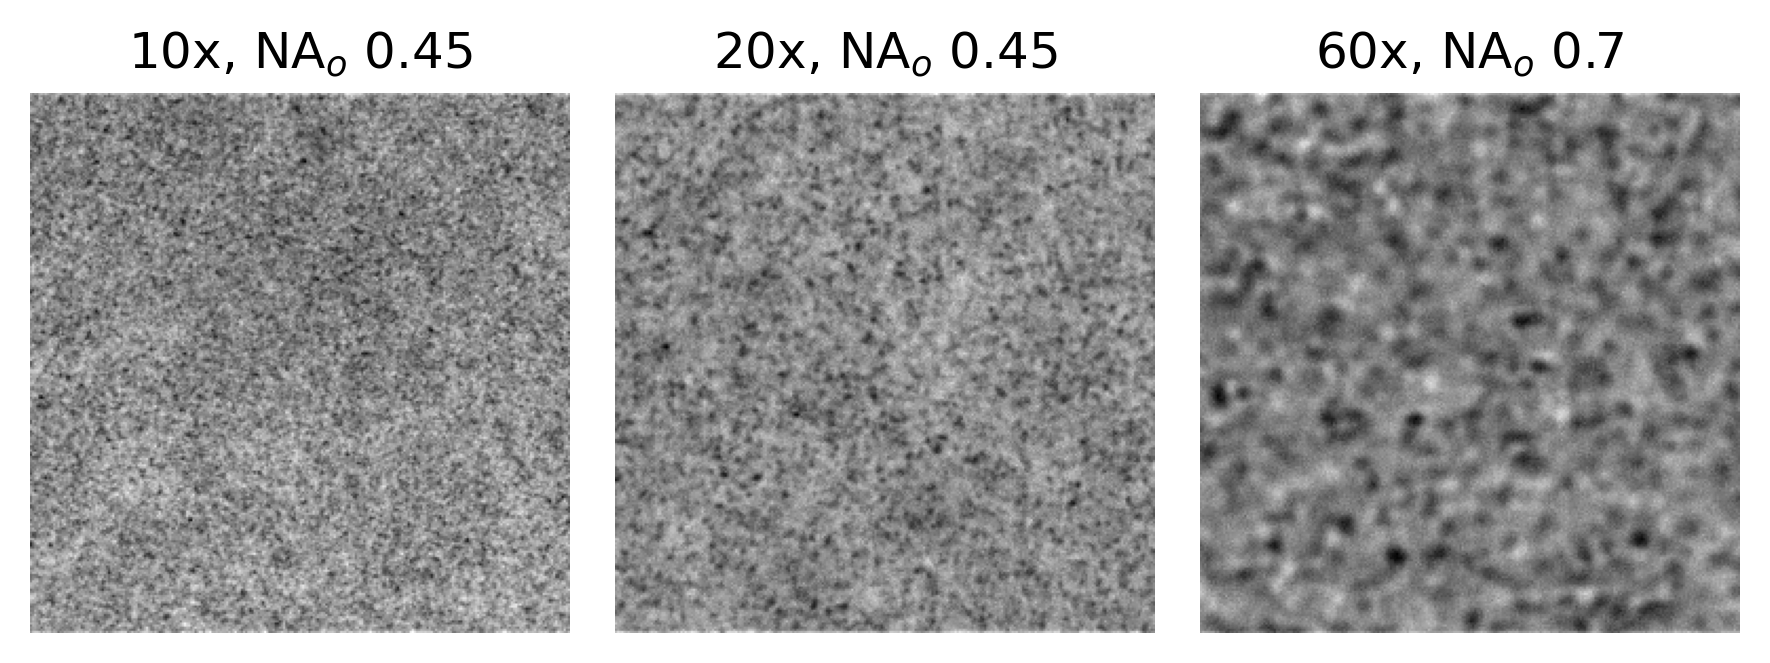

In [3]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=len(file_paths_fast))
axs = gs.subplots()

# read the images
images = [fd.read_images(fp, seq=[0])[0] for fp in file_paths_fast]
images = np.array(images)

for ax, img, label in zip(axs.flatten(), images, labels):
    ax.imshow(img, cmap='gray')
    
    ax.set_axis_off()
    ax.set_title(label)

fig.tight_layout();

Increasing the objective magnification does what you would expect: it zooms in to see tinier things more clearly.

### 1.B-C. Structure function and azimuthal average calculation

The process here mirrors the one outlined in [tutorial2](../Tutorial_2-Melt/tutorial2.ipynb).
Use the following cell to select the `core` and `mode` you wish to use for the calculation of the structure function.

In [4]:
### UNCOMMENT THE CORE YOU WISH TO USE ###
CORE = 'py'
#CORE = 'cpp'
#CORE = 'cuda'

### UNCOMMENT THE MODE YOU WISH TO USE ###
#MODE = 'diff'
MODE = 'fft'

Here, we set the experimental parameters of the acquisition.

In [5]:
# experimental acquisition parameters
magnifications = [10, 20, 60]
pixel_size = [6.5 / mag for mag in magnifications]  # microns per pixel

frame_rate_fast = 108    # frames per second
frame_rate_slow = 1      # frames per second

Finally, we separately compute the structure function and the azimuthal averages for the two acquisitions.
For each pair of azimuthal averages, we compute the melt, which we will keep for the analysis.

In [6]:
print('--- Calculating structure functions and azimuthal averages... ---')

# initialize list of azimuthal averages
aa = []

for num, (fpathf, fpaths) in enumerate(zip(file_paths_fast,
                                           file_paths_slow)):
    # analyze fast acquisition
    # notify user on progress
    print(f'Analyzing fast movie #{num+1} of {len(file_paths_fast)} ...')
    
    # read image sequence
    img_seq = fd.read_images(fpathf)
    
    # compute structure function
    # we analyze delays only up to half the length of the video
    lags = range(1, int(len(img_seq) / 2))
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size[num]
    dqt.set_frame_rate(frame_rate_fast)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                     # number of bins
    bin_range = (0, dqt.ky[-1])                     # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:]) # mask for central cross
    
    aa_fast = fd.azimuthal_average(dqt, bins=bins, range=bin_range,
                                   mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # analyze slow acquisition
    # notify user on progress
    print(f'Analyzing slow movie #{num+1} of {len(file_paths_slow)} ...')
    
    # read image sequence
    img_seq = fd.read_images(fpaths)
    
    # compute structure function
    # we analyze delays only up to half the length of the video
    lags = range(1, int(len(img_seq) / 2))
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size[num]
    dqt.set_frame_rate(frame_rate_slow)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                     # number of bins
    bin_range = (0, dqt.ky[-1])                     # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:]) # mask for central cross
    
    aa_slow = fd.azimuthal_average(dqt, bins=bins, range=bin_range,
                                   mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # melt the azimuthal averages
    aa.append(fd.azimuthalaverage.melt(aa_fast, aa_slow))
    
    # delete unused variables
    del aa_fast, aa_slow
    gc.collect();

--- Calculating structure functions and azimuthal averages... ---
Analyzing fast movie #1 of 3 ...
Analyzing slow movie #1 of 3 ...
Analyzing fast movie #2 of 3 ...
Analyzing slow movie #2 of 3 ...
Analyzing fast movie #3 of 3 ...
Analyzing slow movie #3 of 3 ...


To ease plotting, we compute also resampled azimuthal averages.

In [7]:
# resample melt
aa_resampled = []

for a in aa:
    new_taus = fd.lags.logspace_int(a.tau[-1] // a.tau[0],
                                    num=200) * a.tau[0]
    aa_resampled.append(a.resample(new_taus))

## 2. Fit the data

### 2.A. Estimate noise and amplitude

To give good starting points to the fit routine, we estimate the amplitude and noise term of the structure function.

In [8]:
# estimate noise and amplitude terms
Bq = []
Aq = []

for a in aa:
    B_est, _ = fd.noise_est.estimate_camera_noise(a, mode='polyfit',
                                                  num_points=5)
    Bq.append(B_est) 
    Aq.append(2 * a.var - B_est)

### 2.B. Fit with simple exponential

For particles undergoing Brownian motion, the intermediate scattering function is well-described by a simple exponential function:

$$
f(q, \Delta t) = \exp [- \Gamma(q) \Delta t] ,
$$
where $\Gamma(q) = D q^2$ is the relaxation rate and $D$ is the particles' diffusion coefficient.

We can use the `fastddm.fit_models.simple_exponential_model`, which implements the exponential function in the structure function model:

$$
d(q, \Delta t) = A(q) [1 - \exp(-\Gamma(q) \Delta t)] + B(q) .
$$

In [9]:
from fastddm.fit import fit_multik
from fastddm.fit_models import simple_exponential_model as model

# choose reference k vector
k_ref = 20

To initiate a fitting process with a reliable starting value for the relaxation rate, we can estimate $\tau = 1/\Gamma$ by first estimating the intermediate scattering function and determining the delay where it has a value of $1/\mathrm{e}$.

In [10]:
# initialize lists
fit_res = []
model_res = []

for a, B, A in zip(aa, Bq, Aq):
    # estimate intermediate scattering function at `k_ref`
    fqt = 1 - (a.data[k_ref] - B[k_ref]) / A[k_ref]
    
    # estimate Gamma
    tau = a.tau[np.argmin(np.abs(fqt - np.exp(-1)))]
    Gamma0 = 1 / tau
    
    # set model parameters hints
    model.set_param_hint('A', value=A[k_ref])
    model.set_param_hint('B', value=B[k_ref])
    model.set_param_hint('Gamma', value=Gamma0)
    
    # fit
    fr, mr = fit_multik(a, model, k_ref, use_err=True,
                        return_model_results=True)
    fit_res.append(fr)
    model_res.append(mr)

Now, we can visualize the output from the fit. We first display the comparison of the intermediate scattering function $f(\Delta t; q)$ and the best fit, both obtained by inverting the structure function data and best fit with the resulting $A(q)$ and $B(q)$ from the fit

$$
f(q, \Delta t) = 1 - \frac{d(q, \Delta t) - B(q)}{A(q)}
$$

In [11]:
# select range of wave vector indices
k_min = [0.07, 0.15, 0.44]
k_max = [5, 5, 5]

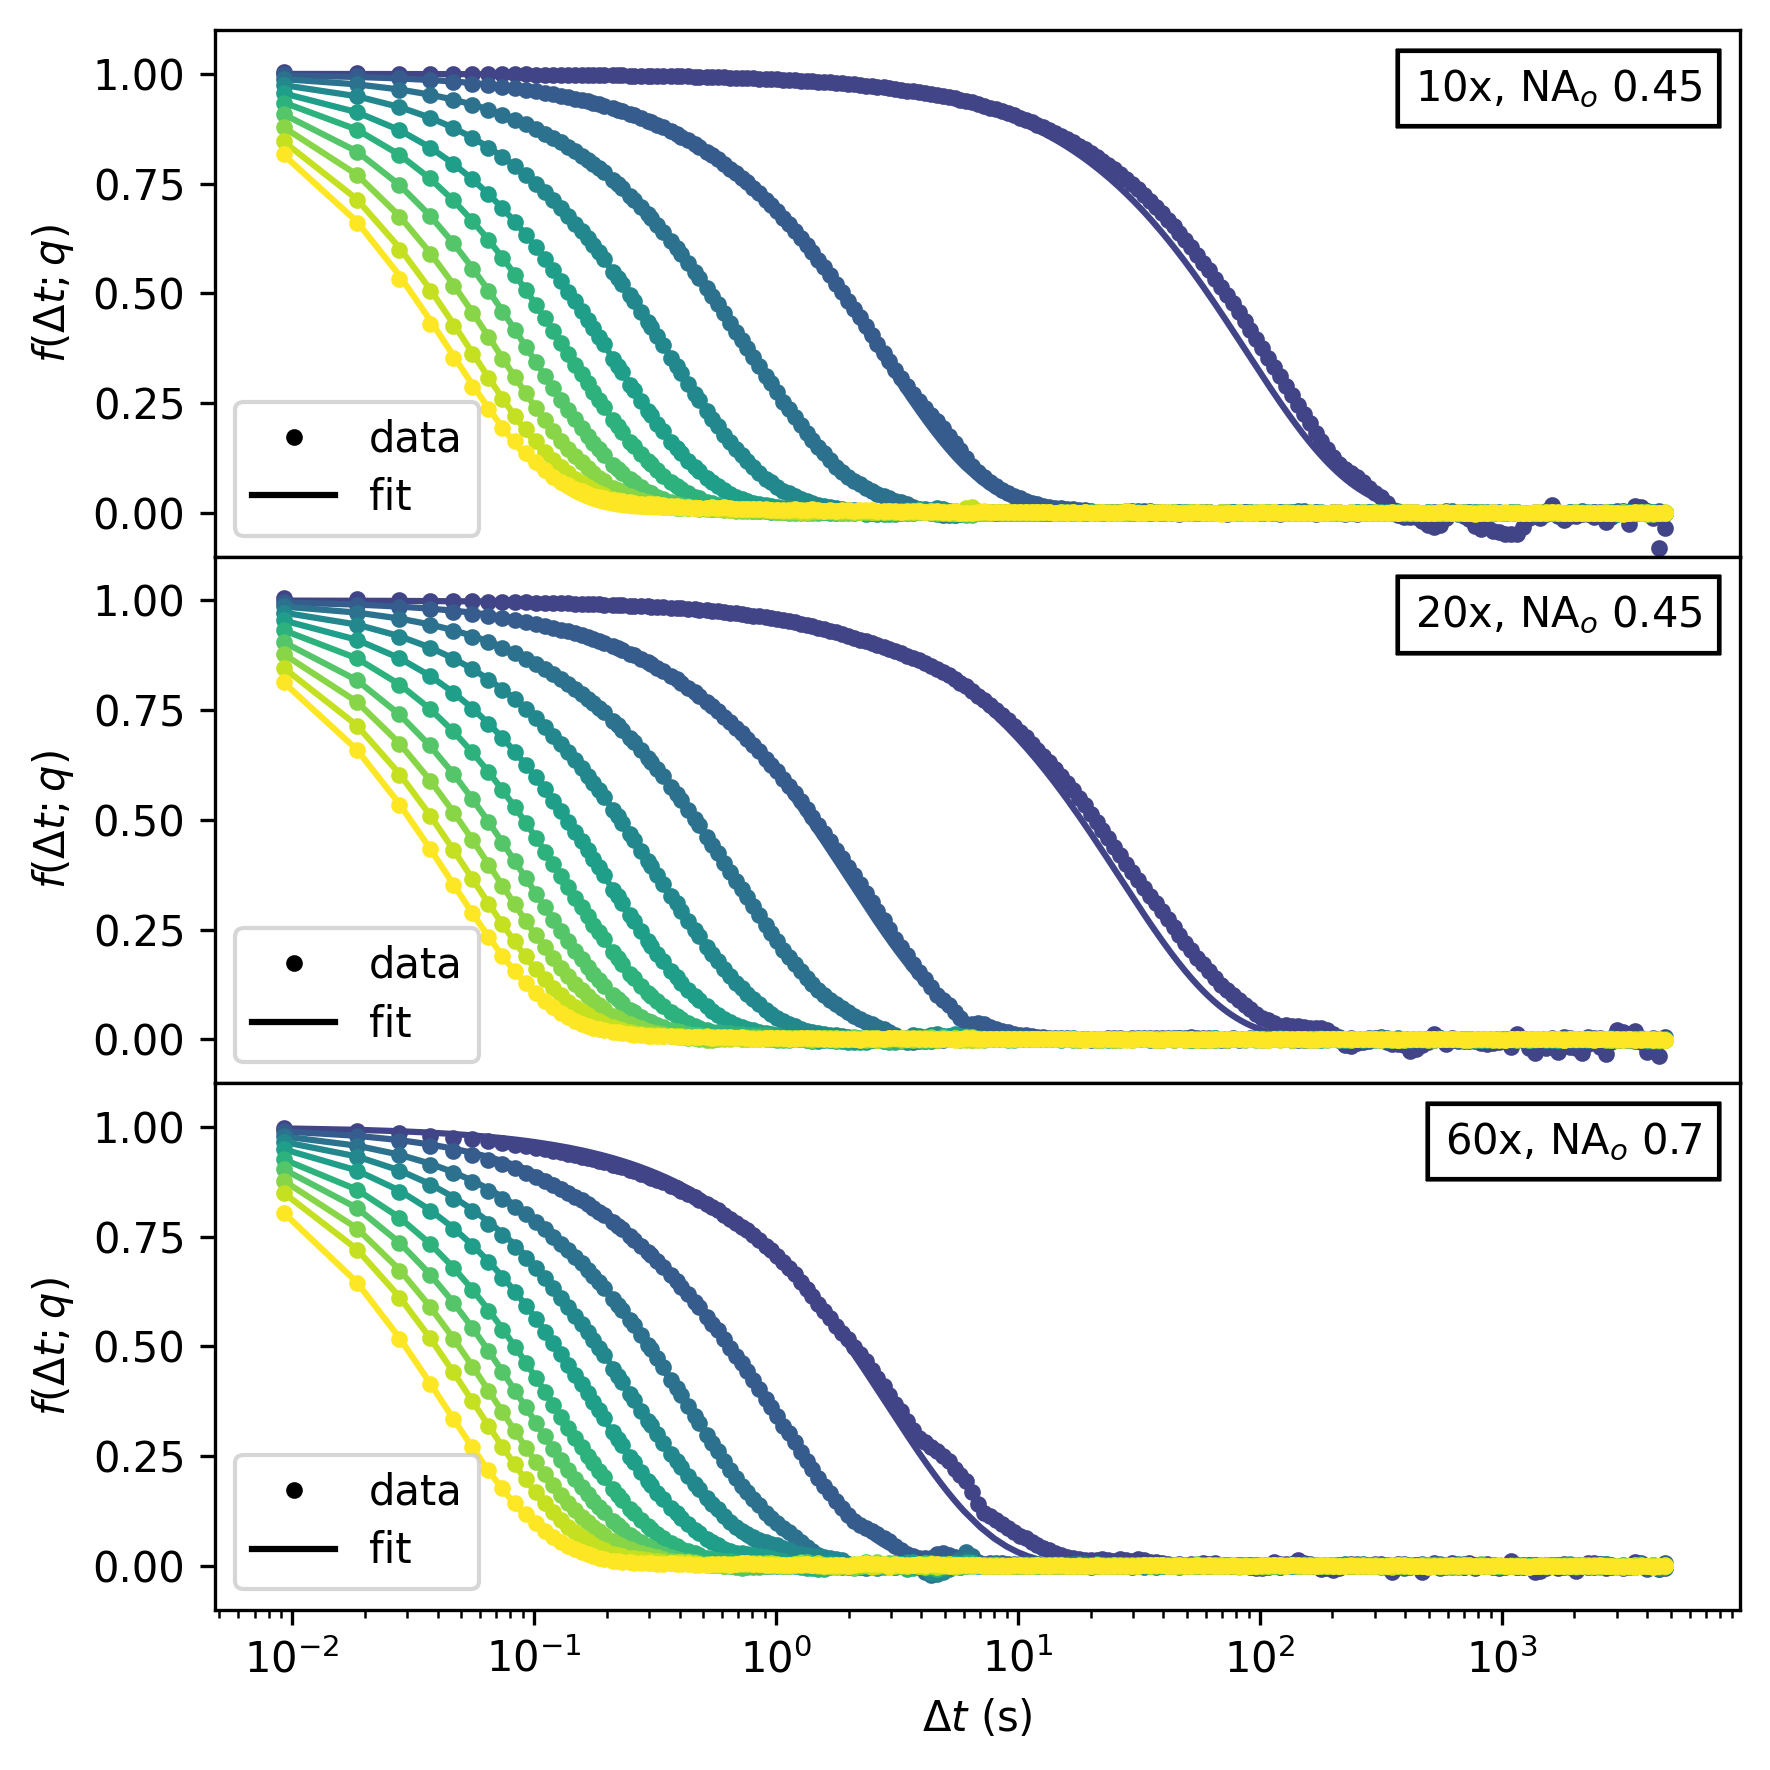

In [12]:
fig = plt.figure()
fig.set_figheight((len(aa) / 2) * fig.get_figheight())
gs = fig.add_gridspec(len(aa), hspace=0)
axs = gs.subplots(sharex=True)

# plot curves
for ax, a, ar, fr, mr, km, kM, l in zip(axs, aa, aa_resampled, fit_res,
                                        model_res, k_min, k_max, labels):
    idx_min = np.argwhere(a.k >= km)[0,0]
    idx_max = np.argwhere(a.k <= kM)[-1,0]
    k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)

    cspace = color_space(len(k_list))
    
    for k_idx, c in zip(k_list, cspace):
        # calculate intermediate scattering function
        fqt = 1 - (ar.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
        fqt_fit = 1 - (mr[k_idx].best_fit - fr['B'][k_idx]) / fr['A'][k_idx]
    
        # plot
        ax.plot(ar.tau, fqt, '.', color=c)
        ax.plot(a.tau, fqt_fit, '-', color=c)
        
        # misc
        ax.set_ylabel(r'$f(\Delta t; q)$')
        ax.set_ylim(-0.1, 1.1)
        # label
        at = AnchoredText(l, prop=dict(size=10), frameon=True,
                          loc='upper right')
        ax.add_artist(at)
        # custom legend
        custom_lines = [
            Line2D([0], [0], marker='.', linestyle='none', color='black',
                   label='data'),
            Line2D([0], [0], linestyle='-', color='black', label='fit'),
        ]
        ax.legend(handles=custom_lines, labelspacing=0.4, loc='lower left')
        
axs[-1].set_xscale('log')
axs[-1].set_xlabel(r'$\Delta t$ (s)')

fig.tight_layout();

**Note:** The colors in the different panels in the above plot correspond to different $q$ vectors. In particular the ranges are as follows:
* 10x: from 0.07 to 5 $\mu$m$^{-1}$
* 20x: from 0.15 to 5 $\mu$m$^{-1}$
* 60x: from 0.44 to 5 $\mu$m$^{-1}$

### 2.C. Effect of objective magnification on the output

Finally, we show the fit parameters, $\Gamma$, $A$, and $B$.
We also display the lower limit $q_{\text{min}}$ defined in [tutorial1](../Tutorial_1-Particle_sizing/tutorial1.ipynb).

In [13]:
# optical parameters
L = np.array([256 * ps for ps in pixel_size])
NAo = np.array([0.45, 0.45, 0.7])
lambda0 = 0.53

# limits
q_min = 2 * np.pi / L
q_max = 2 * np.pi * NAo / lambda0
gamma_0 = 1 / aa[0].tau[0]    # also, gamma_0 = frame_rate
gamma_T = 1 / aa[0].tau[-1]

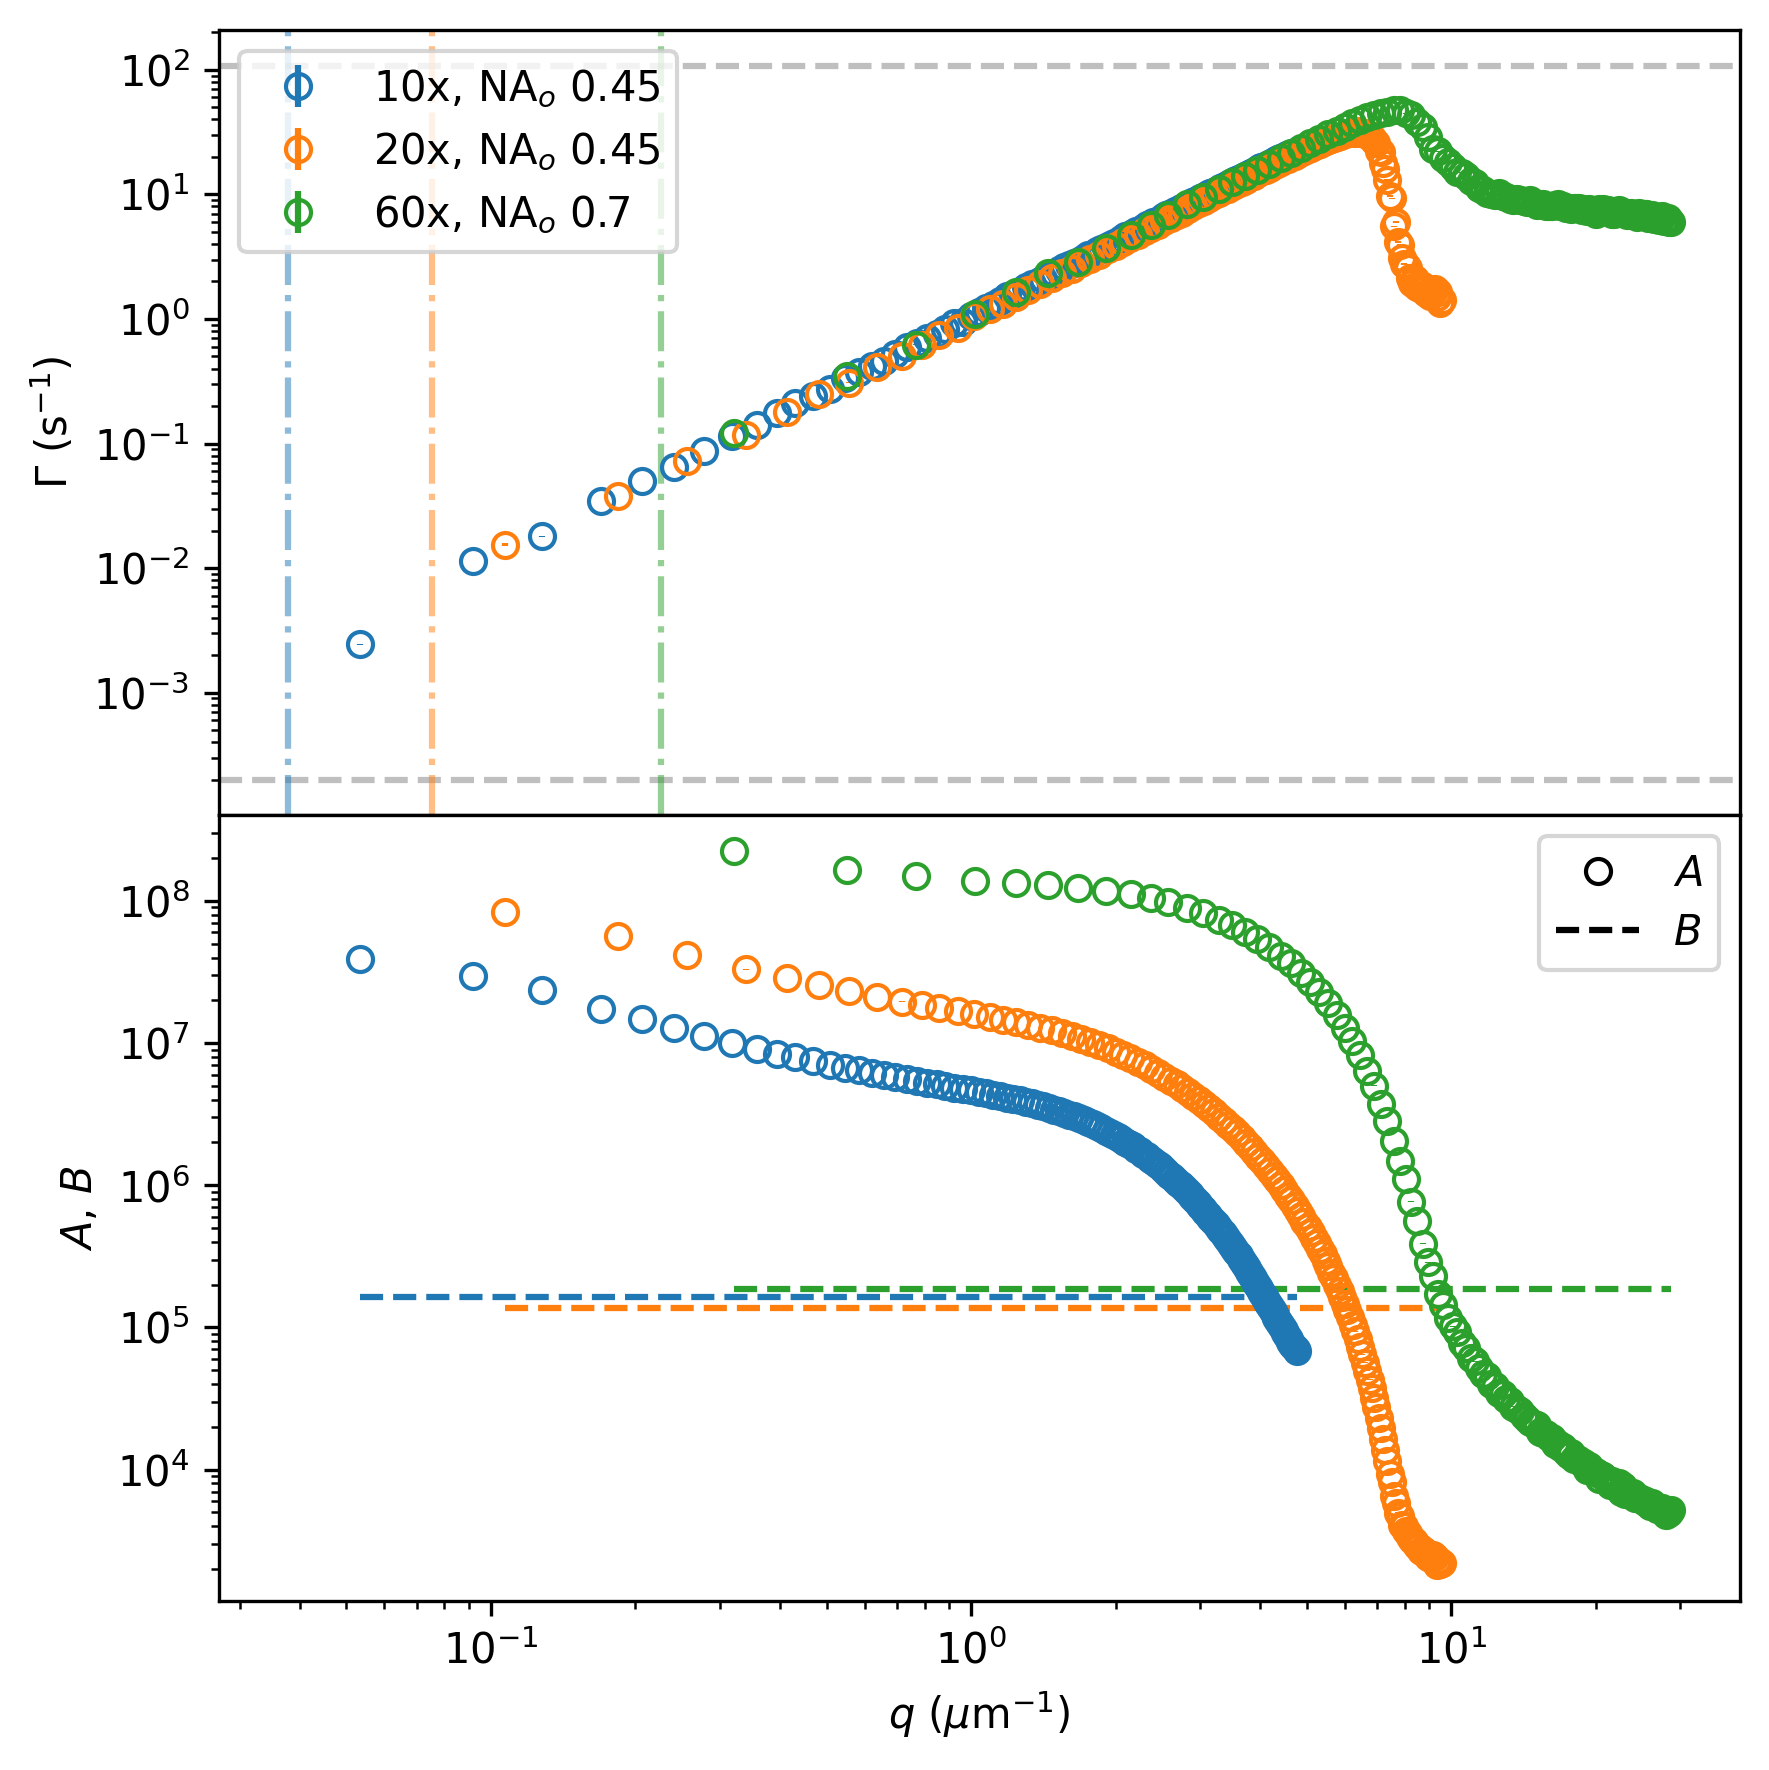

In [14]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
for n, (fr, label) in enumerate(zip(fit_res, labels)):
    # filter only nan and non-successful fits
    tmp_df = fr[fr['success']].dropna()
    
    # display the full data (with transparency)
    axs[0].errorbar(
        tmp_df['k'],
        tmp_df['Gamma'],
        yerr=tmp_df['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        tmp_df['k'],
        tmp_df['A'],
        yerr=tmp_df['A_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
    )
    axs[1].plot(
        tmp_df['k'],
        np.full_like(tmp_df['B'],
                     fill_value=tmp_df[tmp_df['B']>0]['B'].mean()),
        f'C{n}--',
    )

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].legend(loc='upper left')
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none',
           color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

# plot Gamma limits
axs[0].axhline(gamma_T, color='gray', linestyle='--', alpha=0.5)
axs[0].axhline(gamma_0, color='gray', linestyle='--', alpha=0.5)

# plot q limits
for n, qm in enumerate(q_min):
    axs[0].axvline(x=qm, color=f'C{n}', linestyle='-.', alpha=0.5)

fig.tight_layout();

The vertical dash-dotted lines in the upper panel are the $q_{\text{min}} = 2 \pi / L$ limits for the three objectives.
The effect of the objective magnification (at equal image size in pixels) is to shift the lower boundary of the $q$ range proportionally to the magnification itself.

We can again filter the fit results as we saw in the first tutorial.

In [15]:
# filter fit results
fit_res_filtered = []

for fr, qm, qM in zip(fit_res, q_min, q_max):
    # remove non-succesful fits and nans
    tmp_df = fr[fr['success']].dropna()
    
    # filter q range
    tmp_df = tmp_df[(tmp_df['k']>=qm) & (tmp_df['k']<=qM)]
    
    # filter Gamma range
    tmp_df = tmp_df[
        (tmp_df['Gamma']>=gamma_T) & (tmp_df['Gamma']<=gamma_0)
    ]
    
    # append to list
    fit_res_filtered.append(tmp_df)

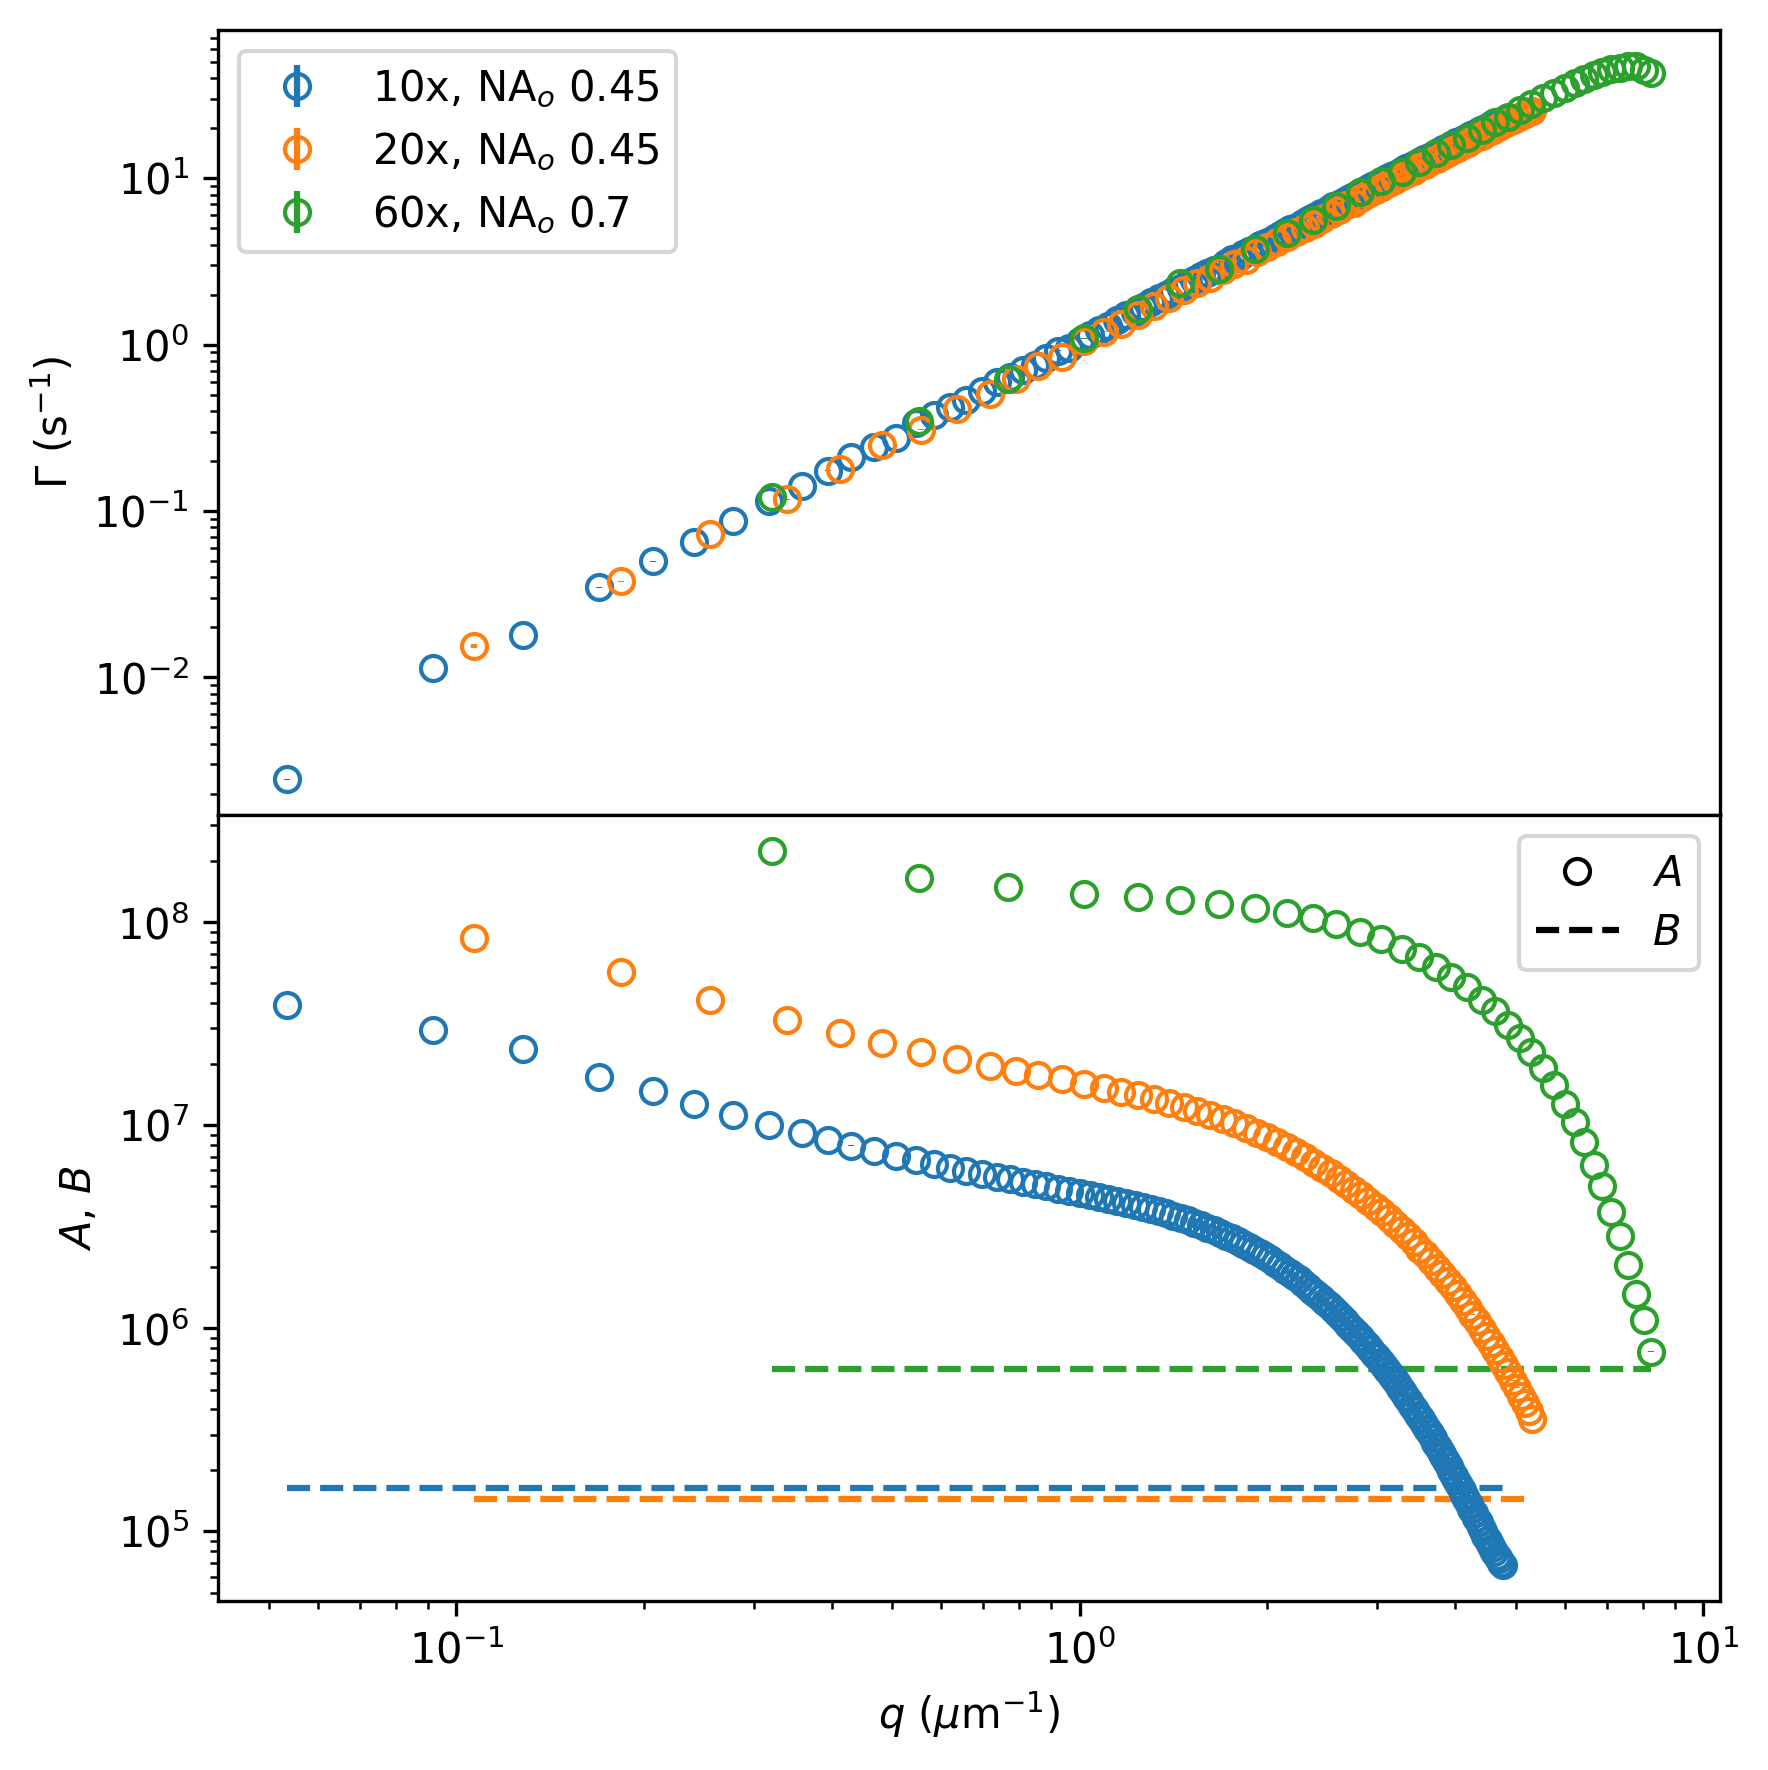

In [16]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
for n, (fr, label) in enumerate(zip(fit_res_filtered, labels)):
    
    # display the full data (with transparency)
    axs[0].errorbar(
        fr['k'],
        fr['Gamma'],
        yerr=fr['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        fr['k'],
        fr['A'],
        yerr=fr['A_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
    )
    axs[1].plot(
        fr['k'],
        np.full_like(fr['B'], fill_value=fr[fr['B']>0]['B'].mean()),
        f'C{n}--',
    )

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].legend()
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none',
           color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

fig.tight_layout();

Notice that the amplitude seems to scale with the square of the objective magnification.
Before investigating further this effect, let's conclude the analysis of the dynamics and compute the diffusion coefficient.

### 2.D. Fit $\Gamma$ to retrieve the diffusion coefficient

For *purely diffusive dynamics*, the relaxation rate and diffusion coefficient $D$ are connected via

$$
\Gamma = D q^2 .
$$
By fitting $\Gamma$ using this power law model, we can extract the diffusion coefficient.

In [17]:
# fit Gamma using Dq^2 model
# we actually fit the logarithm of Gamma, so we define log(Dq^2)
# define model
def log_Dq2(x, D):
    return np.log(D * x**2)
model_Gamma = lmfit.Model(log_Dq2, nan_policy="omit")
model_Gamma.set_param_hint("D", min=0.0, value=1.0)

# fit Gamma
D = []
D_err = []
for fr in fit_res_filtered:
    Gamma_fit_res = fit(model_Gamma,
                        xdata=fr['k'],
                        ydata=np.log(fr['Gamma']),
                        weights=fr['Gamma']/fr['Gamma_stderr'])
    D.append(Gamma_fit_res.params["D"].value)
    D_err.append(Gamma_fit_res.params["D"].stderr)

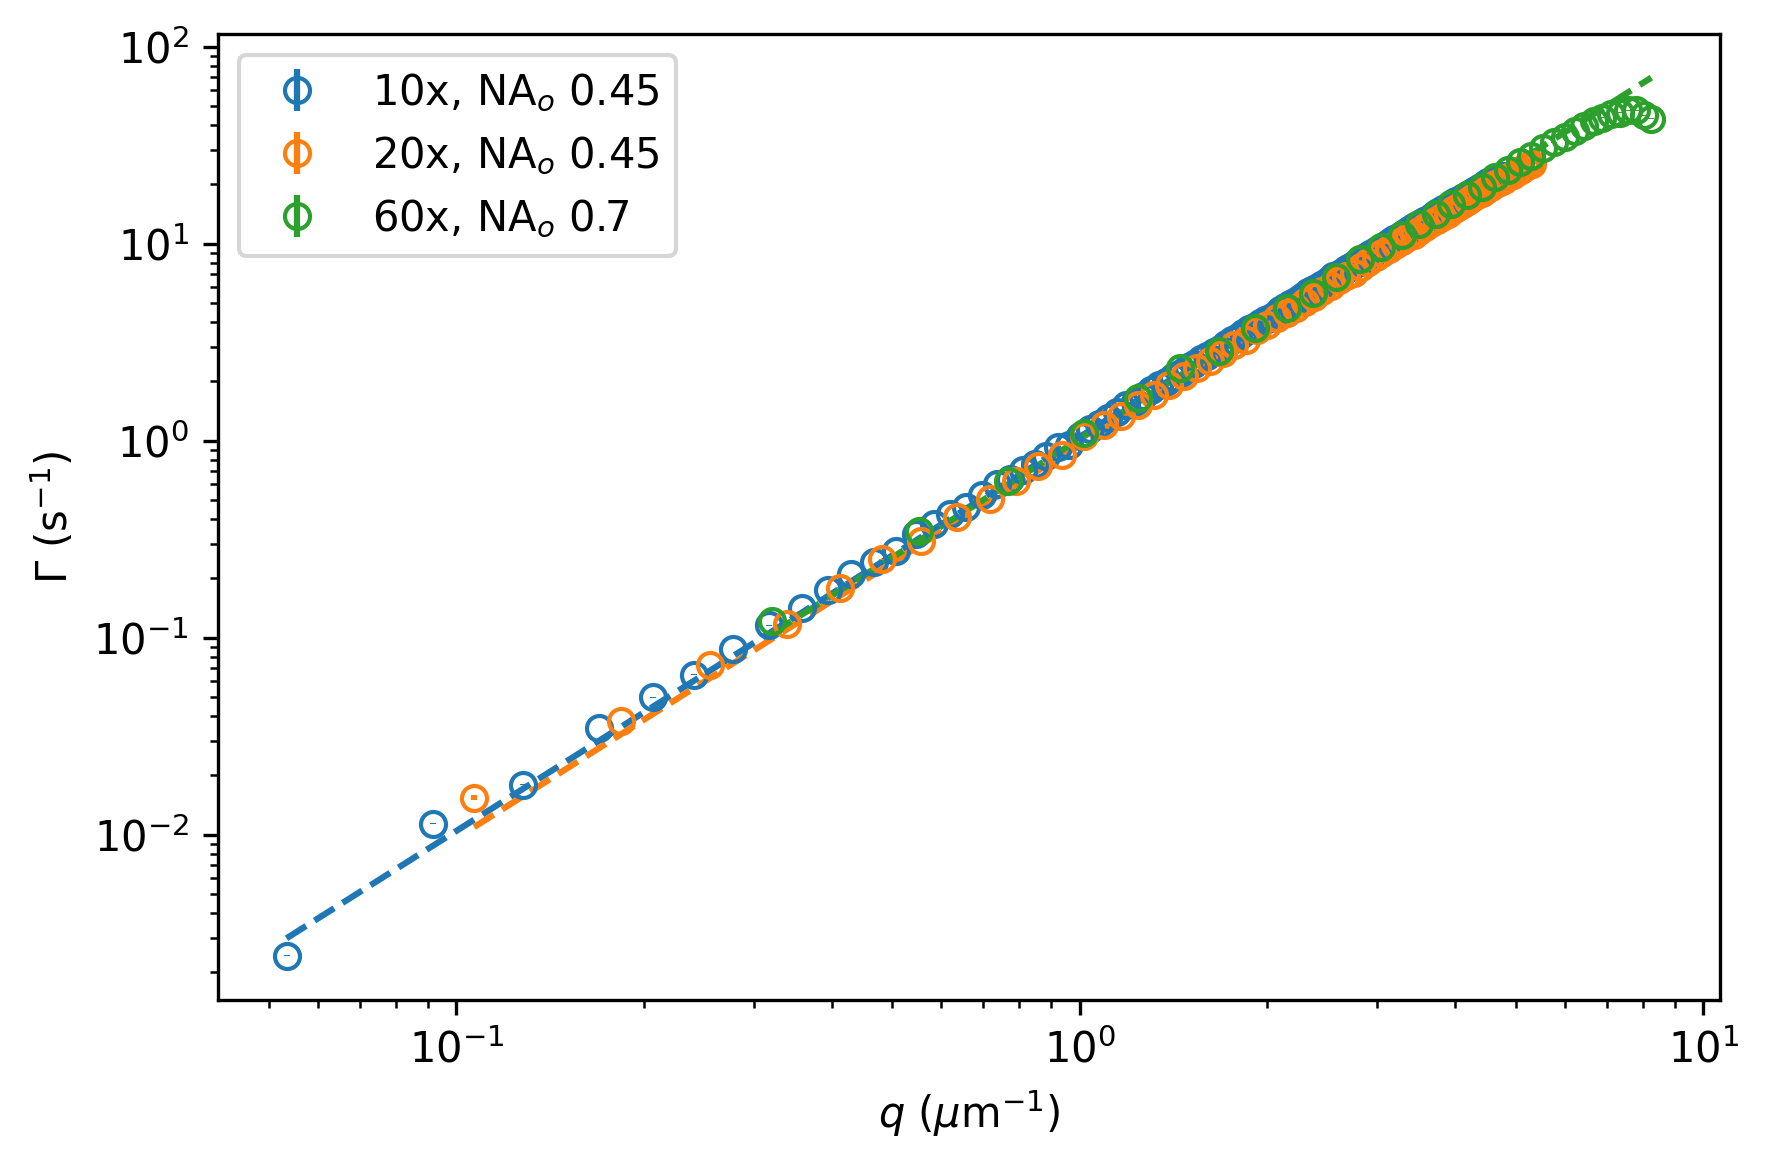

In [18]:
# plot again Gamma with the fit lines
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for n, (frf, label) in enumerate(zip(fit_res_filtered, labels)):
    ax.errorbar(
        frf['k'],
        frf['Gamma'],
        yerr=frf['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    ax.plot(
        frf['k'],
        D[n] * frf['k']**2,
        f'C{n}--'
    )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
ax.legend()

fig.tight_layout();

## 3. Effect of objective magnification and intensity

To investigate the effect of the objective magnification and intensity on $A(q)$ and $B(q)$, we analyze measurements performed on the same sample with the first two objectives (10$\times$ and 20$\times$) and using different lamp intensities, measured as the average signal registered by the camera sensor (10k, 25k, and 50k).
The camera used for this set of measurements was an ORCA-Flash4.0 V3 (Hamamatsu) and each image sequence is composed of 10000 images, 512$\times$512 pixels.
The frame rate for the fast and slow acquisitions are 111 and 1 fps, respectively.
The pixel size is the same of the camera used for the previous set.

The next code cells repeat what we have seen so far, so we will not comment further on them.

In [19]:
# high frame rate videos file names (including enclosing folder)
file_names_fast2 = [
    'PS_252nm_phi_1e-3_10x_NA_0-45_10k/fast.nd2',
    'PS_252nm_phi_1e-3_10x_NA_0-45_25k/fast.nd2',
    'PS_252nm_phi_1e-3_10x_NA_0-45_50k/fast.nd2',
    'PS_252nm_phi_1e-3_20x_NA_0-45_10k/fast.nd2',
    'PS_252nm_phi_1e-3_20x_NA_0-45_25k/fast.nd2',
    'PS_252nm_phi_1e-3_20x_NA_0-45_50k/fast.nd2',
]

# create full paths
file_paths_fast2 = [
    os.path.join(main_directory, fn) for fn in file_names_fast2
]

# low frame rate videos file names (including enclosing folder)
file_names_slow2 = [
    'PS_252nm_phi_1e-3_10x_NA_0-45_10k/slow.nd2',
    'PS_252nm_phi_1e-3_10x_NA_0-45_25k/slow.nd2',
    'PS_252nm_phi_1e-3_10x_NA_0-45_50k/slow.nd2',
    'PS_252nm_phi_1e-3_20x_NA_0-45_10k/slow.nd2',
    'PS_252nm_phi_1e-3_20x_NA_0-45_25k/slow.nd2',
    'PS_252nm_phi_1e-3_20x_NA_0-45_50k/slow.nd2',
]

# create full paths
file_paths_slow2 = [
    os.path.join(main_directory, fn) for fn in file_names_slow2
]

# list of labels
labels2 = [
    r'10x, 10k',
    r'10x, 25k',
    r'10x, 50k',
    r'20x, 10k',
    r'20x, 25k',
    r'20x, 50k',
]

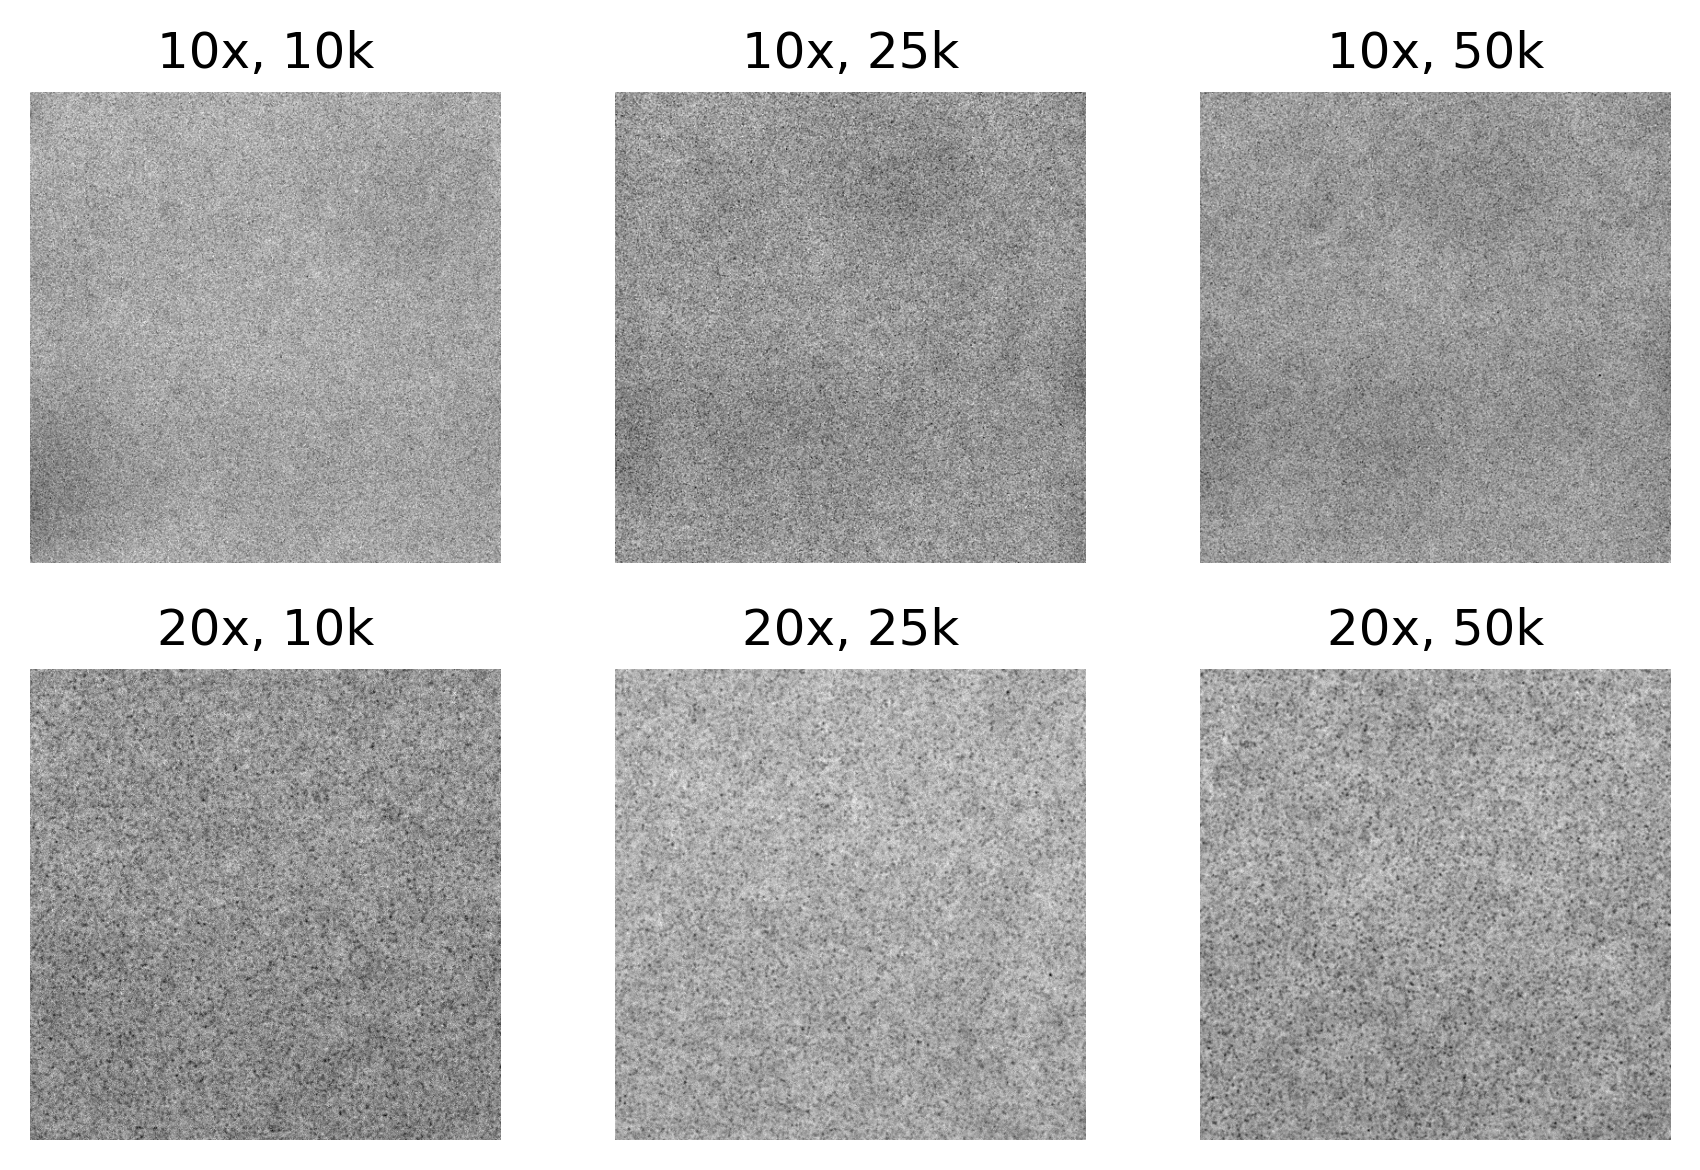

In [20]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=3, nrows=2)
axs = gs.subplots()

# read the images
images = [fd.read_images(fp, seq=[0])[0] for fp in file_paths_fast2]
images = np.array(images)

for ax, img, label in zip(axs.flatten(), images, labels2):
    ax.imshow(img, cmap='gray')
    
    ax.set_axis_off()
    ax.set_title(label)

fig.tight_layout();

In [21]:
# experimental acquisition parameters
magnifications2 = [10, 10, 10, 20, 20, 20]
pixel_size2 = [6.5 / mag for mag in magnifications2]  # microns per pixel

frame_rate_fast2 = 111   # frames per second
frame_rate_slow2 = 1      # frames per second

In [22]:
print('--- Calculating structure functions and azimuthal averages... ---')

# initialize list of azimuthal averages
aa2 = []
avg_int2 = []

for num, (fpathf, fpaths) in enumerate(zip(file_paths_fast2,
                                           file_paths_slow2)):
    # analyze fast acquisition
    # notify user on progress
    print(f'Analyzing fast movie #{num+1} of {len(file_paths_fast2)} ...')
    
    # read image sequence
    img_seq = fd.read_images(fpathf)
    
    # compute structure function
    # we analyze delays only up to half the length of the video
    lags = range(1, int(len(img_seq) / 2))
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size2[num]
    dqt.set_frame_rate(frame_rate_fast2)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                     # number of bins
    bin_range = (0, dqt.ky[-1])                     # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:]) # mask for central cross
    
    aa_fast = fd.azimuthal_average(dqt, bins=bins, range=bin_range,
                                   mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # analyze slow acquisition
    # notify user on progress
    print(f'Analyzing slow movie #{num+1} of {len(file_paths_slow2)} ...')
    
    # read image sequence
    img_seq = fd.read_images(fpaths)
    
    # compute the average intensity
    avg_int2.append(np.mean(img_seq))
    
    # compute structure function
    # we analyze delays only up to half the length of the video
    lags = range(1, int(len(img_seq) / 2))
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size2[num]
    dqt.set_frame_rate(frame_rate_slow2)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                     # number of bins
    bin_range = (0, dqt.ky[-1])                     # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:]) # mask for central cross
    
    aa_slow = fd.azimuthal_average(dqt, bins=bins, range=bin_range,
                                   mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # melt the azimuthal averages
    aa2.append(fd.azimuthalaverage.melt(aa_fast, aa_slow))
    
    # delete unused variables
    del aa_fast, aa_slow
    gc.collect();

--- Calculating structure functions and azimuthal averages... ---
Analyzing fast movie #1 of 6 ...
Analyzing slow movie #1 of 6 ...
Analyzing fast movie #2 of 6 ...
Analyzing slow movie #2 of 6 ...
Analyzing fast movie #3 of 6 ...
Analyzing slow movie #3 of 6 ...
Analyzing fast movie #4 of 6 ...
Analyzing slow movie #4 of 6 ...
Analyzing fast movie #5 of 6 ...
Analyzing slow movie #5 of 6 ...
Analyzing fast movie #6 of 6 ...
Analyzing slow movie #6 of 6 ...


In [23]:
# resample melt
aa_resampled2 = []

for a in aa2:
    new_taus = fd.lags.logspace_int(a.tau[-1] // a.tau[0],
                                    num=200) * a.tau[0]
    aa_resampled2.append(a.resample(new_taus))

In [24]:
# estimate noise and amplitude terms
Bq2 = []
Aq2 = []

for a in aa2:
    B_est, _ = fd.noise_est.estimate_camera_noise(a, mode='polyfit',
                                                  num_points=5)
    Bq2.append(B_est) 
    Aq2.append(2 * a.var - B_est)

In [25]:
# fit data
# initialize lists
fit_res2 = []
model_res2 = []

for a, B, A in zip(aa2, Bq2, Aq2):
    # estimate intermediate scattering function at `k_ref`
    fqt = 1 - (a.data[k_ref] - B[k_ref]) / A[k_ref]
    
    # estimate Gamma
    tau = a.tau[np.argmin(np.abs(fqt - np.exp(-1)))]
    Gamma0 = 1 / tau
    
    # set model parameters hints
    model.set_param_hint('A', value=A[k_ref])
    model.set_param_hint('B', value=B[k_ref])
    model.set_param_hint('Gamma', value=Gamma0)
    
    # fit
    fr, mr = fit_multik(a, model, k_ref, use_err=True,
                        return_model_results=True)
    fit_res2.append(fr)
    model_res2.append(mr)

In [26]:
# optical parameters
L2 = np.array([512 * ps for ps in pixel_size2])
NAo2 = 0.45

# limits
q_min2 = 2 * np.pi / L2
q_max2 = 2 * np.pi * NAo2 / lambda0
gamma_02 = 1 / aa2[0].tau[0]    # also, gamma_0 = frame_rate
gamma_T2 = 1 / aa2[0].tau[-1]

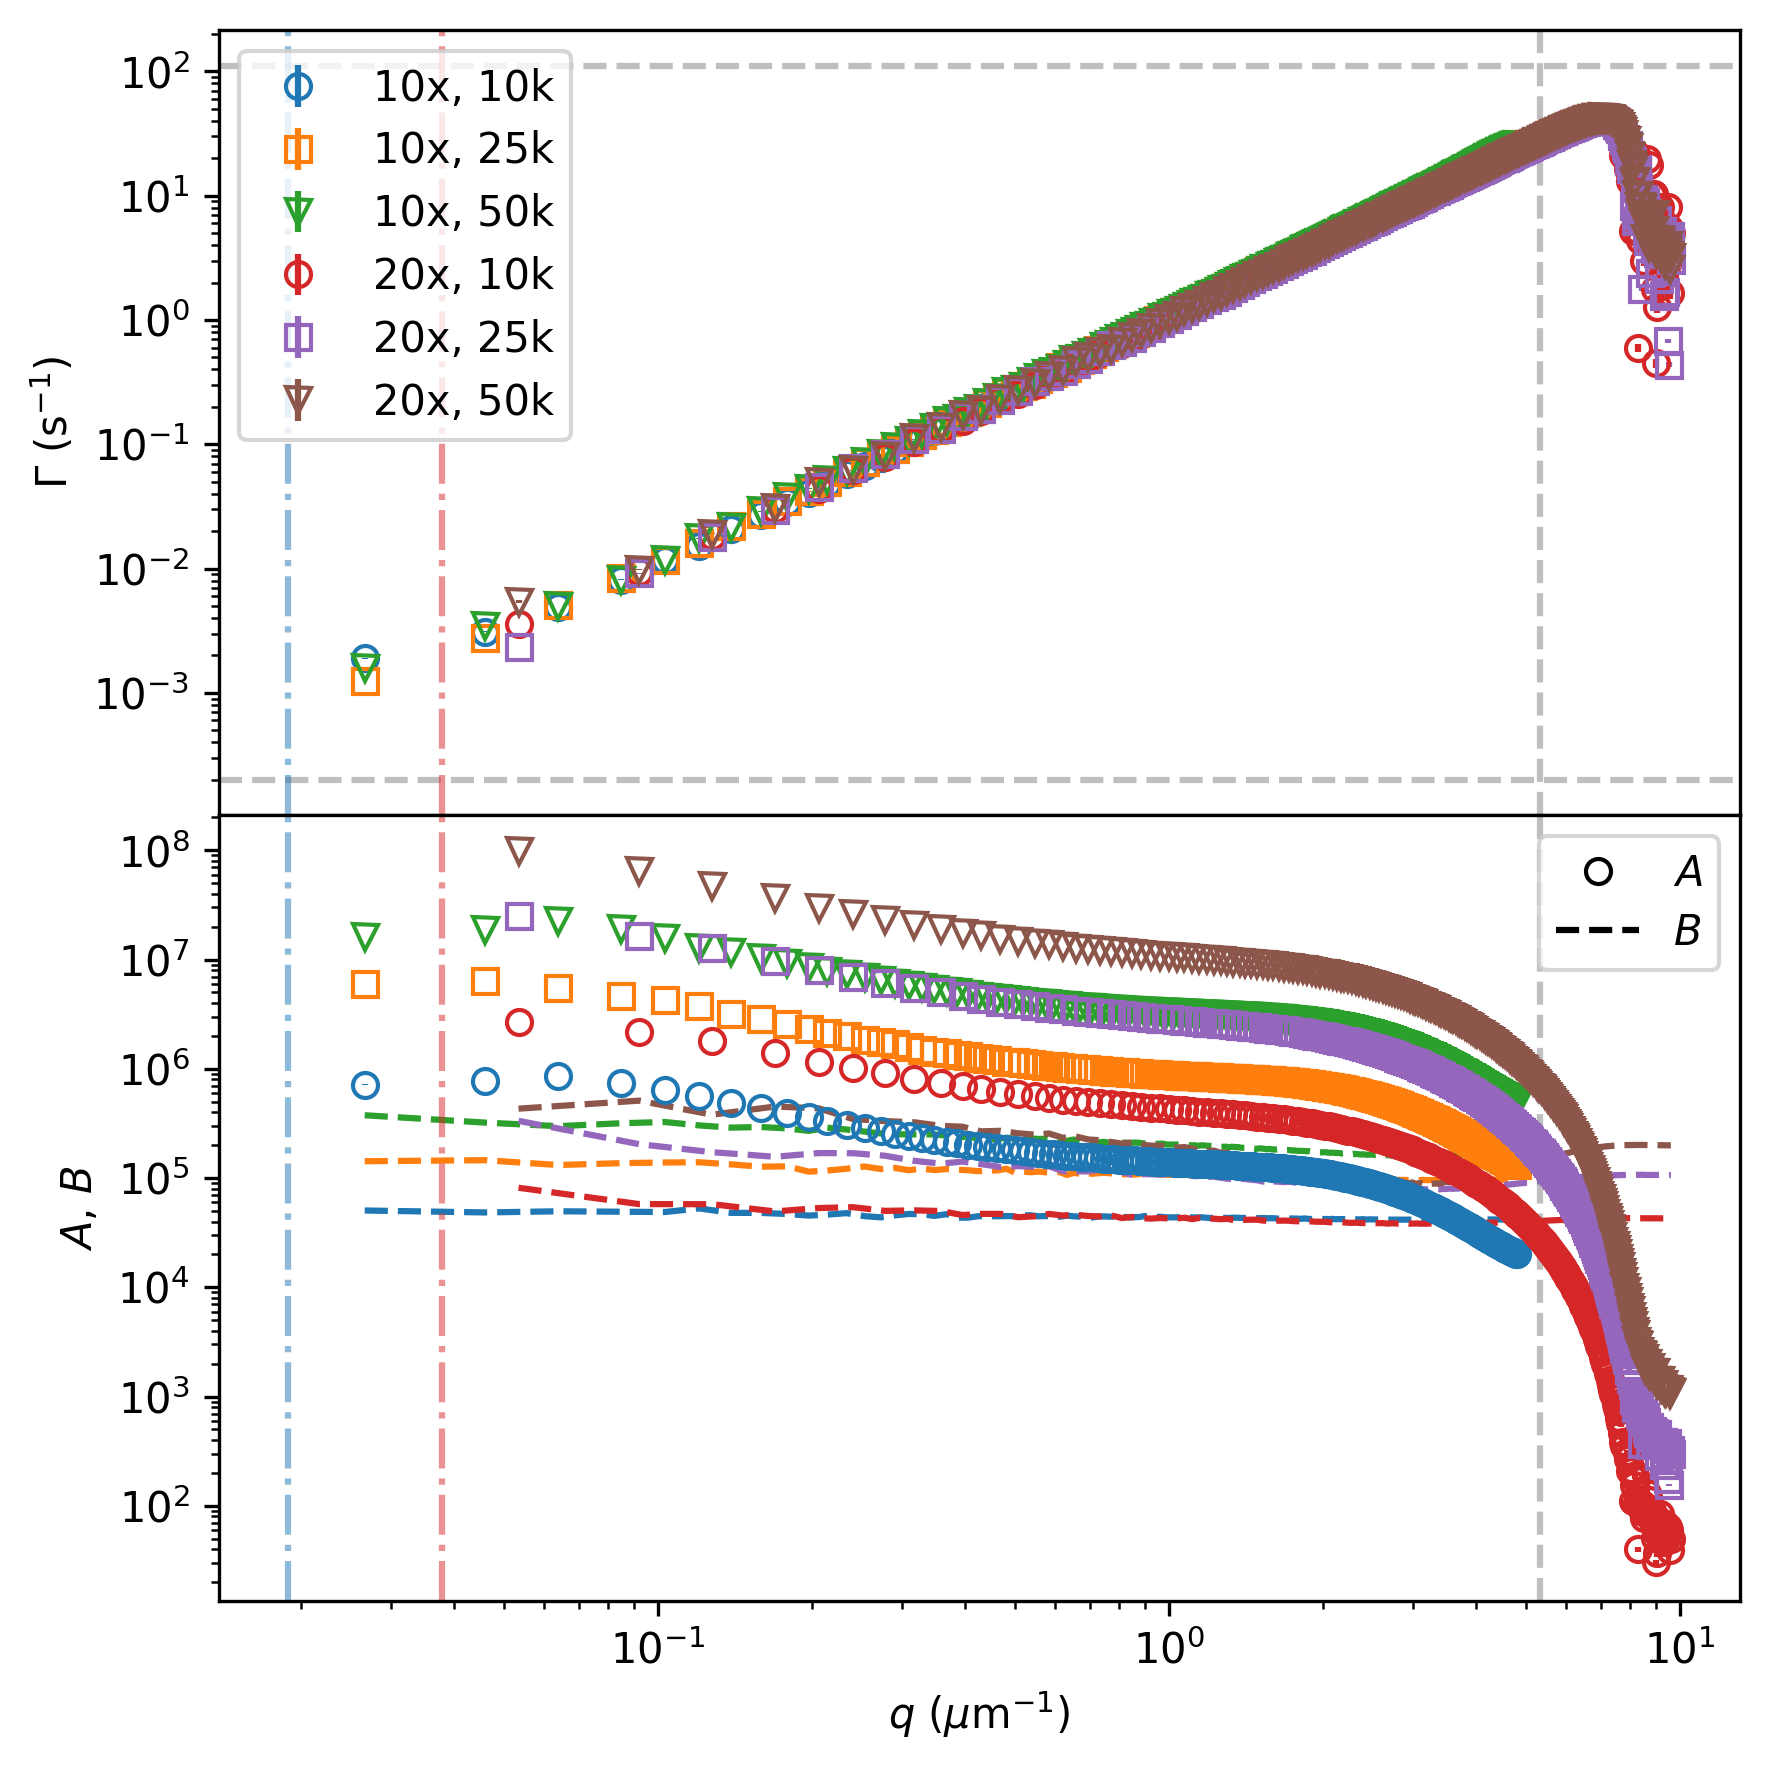

In [27]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
markers2 = ['o', 's', 'v'] * 2
for n, (fr, marker, label) in enumerate(zip(fit_res2, markers2, labels2)):
    # filter only nan and non-successful fits
    tmp_df = fr[fr['success']].dropna()
    
    # display the full data (with transparency)
    axs[0].errorbar(
        tmp_df['k'],
        tmp_df['Gamma'],
        yerr=tmp_df['Gamma_stderr'],
        fmt=f'C{n}{marker}',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        tmp_df['k'],
        tmp_df['A'],
        yerr=tmp_df['A_stderr'],
        fmt=f'C{n}{marker}',
        markerfacecolor='none',
    )
    axs[1].plot(
        tmp_df['k'],
        tmp_df['B'],
        f'C{n}--',
    )

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].legend(loc='upper left')
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none',
           color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

# plot Gamma limits
axs[0].axhline(gamma_T2, color='gray', linestyle='--', alpha=0.5)
axs[0].axhline(gamma_02, color='gray', linestyle='--', alpha=0.5)

# plot q limits
axs[0].axvline(x=q_min2[0], color='C0', linestyle='-.', alpha=0.5)
axs[0].axvline(x=q_min2[-1], color='C3', linestyle='-.', alpha=0.5)
axs[1].axvline(x=q_min2[0], color='C0', linestyle='-.', alpha=0.5)
axs[1].axvline(x=q_min2[-1], color='C3', linestyle='-.', alpha=0.5)
axs[0].axvline(x=q_max2, color='gray', linestyle='--', alpha=0.5)
axs[1].axvline(x=q_max2, color='gray', linestyle='--', alpha=0.5)

fig.tight_layout();

No surprises from the relaxation rate.
Let's filter the data and inspect the amplitude.

In [28]:
# filter fit results
fit_res_filtered2 = []

for fr, qm in zip(fit_res2, q_min2):
    # remove non-succesful fits and nans
    tmp_df = fr[fr['success']].dropna()
    
    # filter q range
    tmp_df = tmp_df[(tmp_df['k']>=qm) & (tmp_df['k']<=q_max2)]
    
    # filter Gamma range
    tmp_df = tmp_df[
        (tmp_df['Gamma']>=gamma_T2) & (tmp_df['Gamma']<=gamma_02)
    ]
    
    # append to list
    fit_res_filtered2.append(tmp_df)

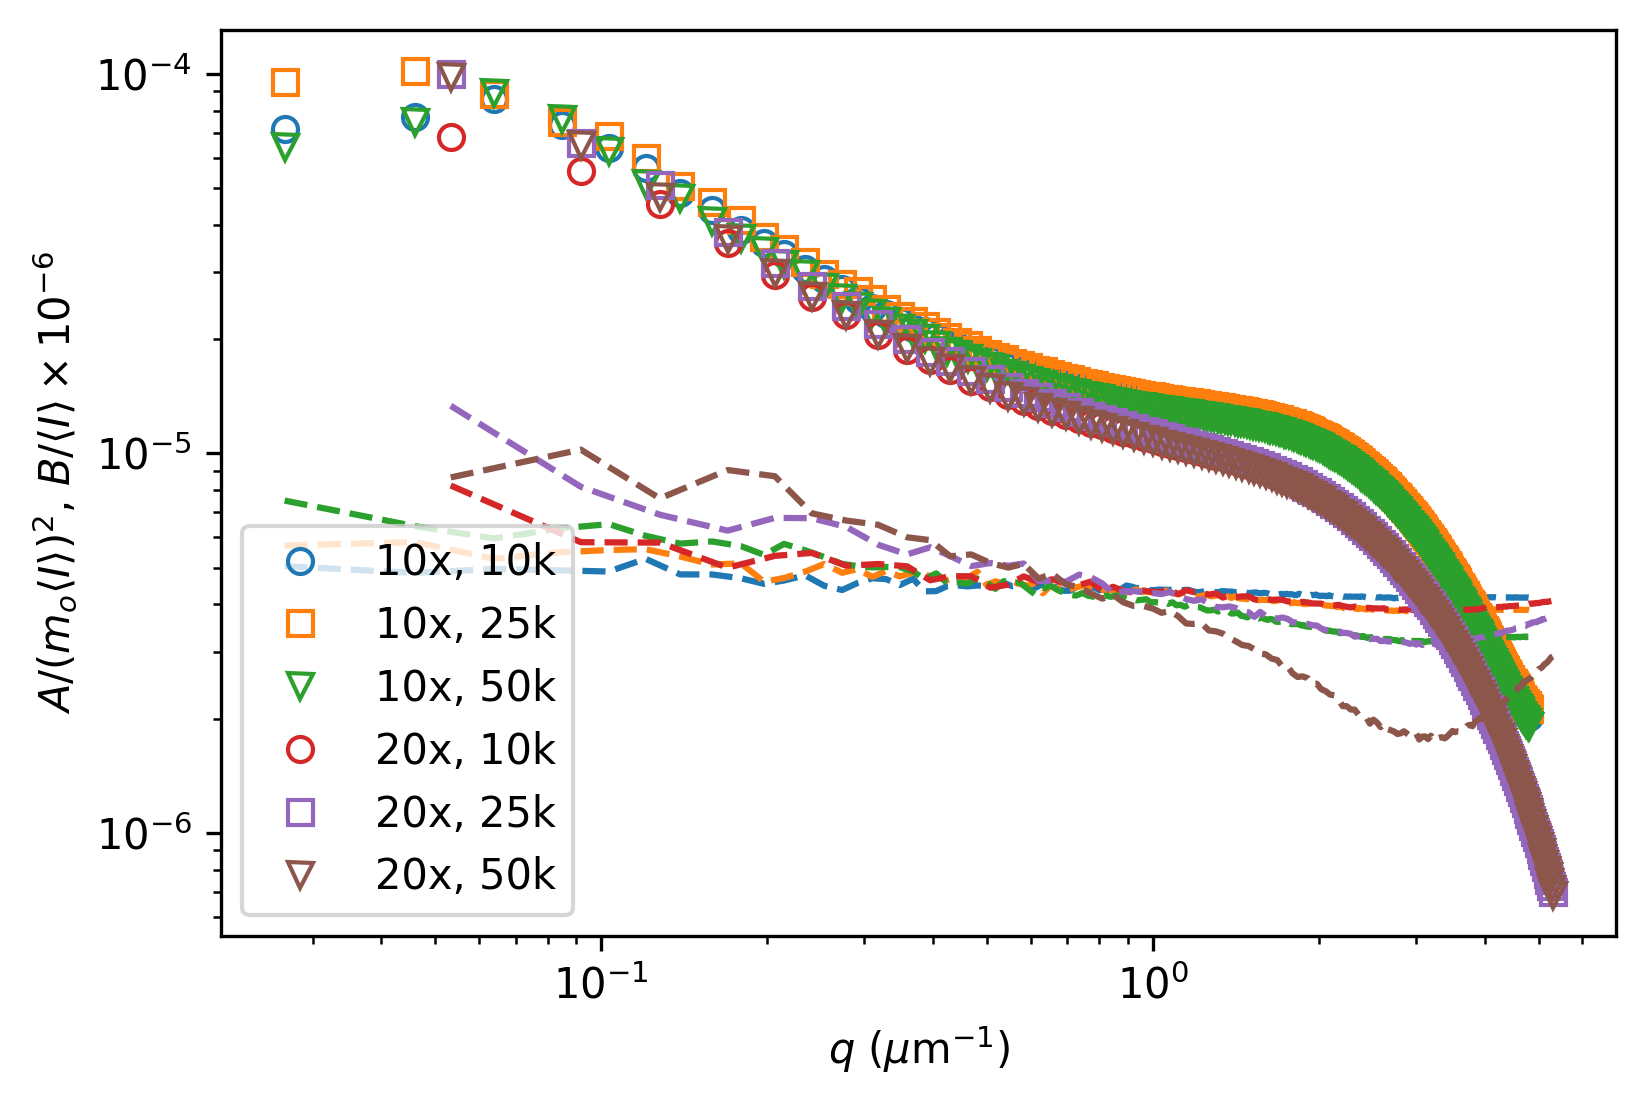

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for n, (fr, avgI, mo, marker, label) in enumerate(zip(fit_res_filtered2,
                                                      avg_int2,
                                                      magnifications2,
                                                      markers2,
                                                      labels2)):
    ax.plot(fr['k'], fr['A'] / (mo**2 * avgI**2), f'C{n}{marker}',
            markerfacecolor='none', label=label)
    ax.plot(fr['k'], fr['B'] / avgI * 1e-6, f'C{n}--')
    
ax.set_xscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_yscale('log')
ax.set_ylabel(
    (r'$A / (m_o \langle I \rangle)^2$, $B / '
     r'\langle I \rangle \times 10^{-6}$')
)
ax.legend()

Every other parameter fixed, the amplitude scales with the square of the objective magnification $m_o$ and of the average intensity $\langle I(\mathbf{x}, t) \rangle_{\mathbf{x}, t}$.
The noise, instead, is proportional to the average intensity.

# (\*) Figures for paper

This last section is not part of the tutorial. If you are interested in getting the images used for the particle sizing section of our publication, feel free to set the following flag to `True` and run the cells below. You will need the `scienceplots` package, which is not among the ones required for these tutorials. You can install it through `pip`.

In [30]:
save_figures = False

In [31]:
if save_figures:
    # --- imports ---
    import scienceplots

    plt.style.use(['science', 'nature', 'vibrant'])
    mpl.rcParams['lines.markeredgewidth'] = 0.7
    
    # create FIGS directory
    os.makedirs('FIGS', exist_ok=True)

### Export images

In [32]:
if save_figures:
    # --- save comparison f(q, dt) / fit (first set) ---
    fig = plt.figure()
    fig.set_figheight((len(aa) / 2) * fig.get_figheight())
    gs = fig.add_gridspec(len(aa), hspace=0)
    axs = gs.subplots(sharex=True)

    # plot curves
    for ax, a, ar, fr, mr, km, kM, l in zip(axs, aa, aa_resampled, fit_res,
                                            model_res, k_min, k_max,
                                            labels):
        idx_min = np.argwhere(a.k >= km)[0,0]
        idx_max = np.argwhere(a.k <= kM)[-1,0]
        k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)

        cspace = color_space(len(k_list))
    
        for k_idx, c in zip(k_list, cspace):
            # calculate intermediate scattering function
            fqt = 1 - (ar.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
            fqt_fit = ( 1 - \
                       (mr[k_idx].best_fit - fr['B'][k_idx]) / \
                       fr['A'][k_idx] )
    
            # plot
            ax.plot(ar.tau, fqt, '.', color=c)
            ax.plot(a.tau, fqt_fit, '-', color=c)
        
            # misc
            ax.set_ylabel(r'$f(\Delta t; q)$')
            ax.set_ylim(-0.1, 1.1)
            # label
            at = AnchoredText(l, prop=dict(size=10), frameon=True,
                              loc='upper right')
            ax.add_artist(at)
            # custom legend
            custom_lines = [
                Line2D([0], [0], marker='.', linestyle='none',
                       color='black', label='data'),
                Line2D([0], [0], linestyle='-', color='black',
                       label='fit'),
            ]
            ax.legend(handles=custom_lines, labelspacing=0.4,
                      loc='center right')
        
    axs[-1].set_xscale('log')
    axs[-1].set_xlabel(r'$\Delta t$ (s)')

    fig.tight_layout()
    
    fig.savefig('FIGS/fqt_1.pdf', dpi=600)

In [33]:
if save_figures:
    # --- save comparison f(q, dt) / fit (second set) ---
    fig = plt.figure()
    fig.set_figheight((len(aa2) / 2) * fig.get_figheight())
    gs = fig.add_gridspec(len(aa2), hspace=0)
    axs = gs.subplots(sharex=True)
    
    k_min2 = [k_min[0]] * 3 + [k_min[1]] * 3
    k_max2 = [k_max[0]] * 3 + [k_max[1]] * 3

    # plot curves
    for ax, a, ar, fr, mr, km, kM, l in zip(axs, aa2, aa_resampled2,
                                            fit_res2, model_res2, k_min2,
                                            k_max2, labels2):
        idx_min = np.argwhere(a.k >= km)[0,0]
        idx_max = np.argwhere(a.k <= kM)[-1,0]
        k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)

        cspace = color_space(len(k_list))
    
        for k_idx, c in zip(k_list, cspace):
            # calculate intermediate scattering function
            fqt = 1 - (ar.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
            fqt_fit = ( 1 - \
                       (mr[k_idx].best_fit - fr['B'][k_idx]) / \
                       fr['A'][k_idx] )
    
            # plot
            ax.plot(ar.tau, fqt, '.', color=c)
            ax.plot(a.tau, fqt_fit, '-', color=c)
        
            # misc
            ax.set_ylabel(r'$f(\Delta t; q)$')
            ax.set_ylim(-0.1, 1.1)
            # label
            at = AnchoredText(l, prop=dict(size=10), frameon=True,
                              loc='upper right')
            ax.add_artist(at)
            # custom legend
            custom_lines = [
                Line2D([0], [0], marker='.', linestyle='none',
                       color='black', label='data'),
                Line2D([0], [0], linestyle='-', color='black',
                       label='fit'),
            ]
            ax.legend(handles=custom_lines, labelspacing=0.4,
                      loc='center right')
        
    axs[-1].set_xscale('log')
    axs[-1].set_xlabel(r'$\Delta t$ (s)')

    fig.tight_layout()
    
    fig.savefig('FIGS/fqt_2.pdf', dpi=600)

In [34]:
if save_figures:
    # --- save fit parameters (first set) ---
    fig = plt.figure()
    fig.set_figheight(1.7 * fig.get_figheight())
    gs = fig.add_gridspec(2, hspace=0)
    axs = gs.subplots(sharex=True)
    
    for n, (fr, frf, d, label) in enumerate(zip(fit_res, fit_res_filtered,
                                                D, labels)):
        # plot Gamma
        axs[0].plot(frf['k'], frf['Gamma'],
                    f'C{n}o', markerfacecolor='none',
                    label=label)
        
        # plot fit line
        axs[0].plot(frf['k'], d * frf['k']**2,
                    f'C{n}--')
        
        # plot A
        axs[1].plot(frf['k'], frf['A'],
                    f'C{n}o', markerfacecolor='none')
        
        # plot B
        axs[1].plot(frf['k'],
                    np.full_like(frf['B'],
                                 fill_value=frf[frf['B']>0]['B'].mean()),
                    f'C{n}--')
    
    # plot q_min limit
    for n, qm in enumerate(q_min):
        axs[0].axvline(x=qm, color=f'C{n}', linestyle='-.', alpha=0.8)
        axs[1].axvline(x=qm, color=f'C{n}', linestyle='-.', alpha=0.8)
    
    # settings
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
    axs[0].legend()
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
    axs[1].set_ylabel(r'$A$, $B$')
    custom_lines = [
        Line2D([0], [0], marker='o', linestyle='none',
               markerfacecolor='none', color='black', label=r'$A$'),
        Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
    ]
    axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')
    
    # plot panel label   
    at = [
        AnchoredText("a)", prop=dict(size=10), frameon=False,
                     loc='upper left'),
        AnchoredText("b)", prop=dict(size=10), frameon=False,
                     loc='upper left'),
    ]
    for a, _at in zip(axs, at):
        a.add_artist(_at)
    
    fig.tight_layout()
    
    fig.savefig('FIGS/Gamma_AB_1.pdf', dpi=600)

In [35]:
if save_figures:
    # --- save amplitude (second set) ---
    fig = plt.figure()
    fig.set_figheight(1.7 * fig.get_figheight())
    gs = fig.add_gridspec(2, hspace=0)
    axs = gs.subplots(sharex=True)
    
    mrks = ['o', 's', 'v'] * 2
    
    for n, (frf, avgI, mo, m, label) in enumerate(zip(fit_res_filtered2,
                                                      avg_int2,
                                                      magnifications2,
                                                      mrks,
                                                      labels2)):
        # plot A
        if n > 2:
            axs[0].plot(frf['k'], frf['A'],
                        f'C{n}{m}', markerfacecolor='none',
                        label=label)
        else:
            axs[0].plot(frf['k'], frf['A'],
                        f'C{n}{m}',
                        label=label)
        
        # plot B
        axs[0].plot(frf['k'],
                    frf['B'],
                    f'C{n}--')
        
        # plot scaled A
        if n > 2:
            axs[1].plot(frf['k'], frf['A'] / (mo * avgI)**2,
                        f'C{n}{m}', markerfacecolor='none',
                        label=label)
        else:
            axs[1].plot(frf['k'], frf['A'] / (mo * avgI)**2,
                        f'C{n}{m}',
                        label=label)
        
        # plot scaled B
        axs[1].plot(frf['k'],
                    frf['B'] / avgI * 1e-6,
                    f'C{n}--')
    
    # settings
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'$A$, $B$')
    axs[0].legend(labelspacing=0.4, ncol=2, columnspacing=0.8)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
    axs[1].set_ylabel(
        (r'$A / (m_o \langle I \rangle)^2$, $B / '
         r'\langle I \rangle \times 10^{-6}$')
    )
    custom_lines = [
        Line2D([0], [0], marker='o', linestyle='none',
               markerfacecolor='none', color='black', label=r'$A$'),
        Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
    ]
    axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')
    
    # plot panel label   
    at = [
        AnchoredText("a)", prop=dict(size=10), frameon=False,
                     loc='upper left'),
        AnchoredText("b)", prop=dict(size=10), frameon=False,
                     loc='lower left'),
    ]
    for a, _at in zip(axs, at):
        a.add_artist(_at)
    
    fig.tight_layout()
    
    fig.savefig('FIGS/AB_2.pdf', dpi=600)